In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, r2_score,roc_auc_score, root_mean_squared_error
from sklearn.model_selection import train_test_split
import catboost as cb
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from matplotlib import pyplot as plt

In [7]:
filepath = "properties_data_set_19_11_20H00.csv"
df = pd.read_csv(filepath)
df.set_index("house_index",drop=True, inplace=True )

In [44]:
df['property_type'].unique()

array(['APARTMENT', 'HOUSE'], dtype=object)

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from scipy import stats


#Additional data cleaning and renaming
df = df[df['price'] >= 40000]
df = df[df['bedrooms'] <= 9]
df['house_index'] = range(1, len(df) + 1)

df['buildingState'] = df['buildingState'].replace({
    'AS_NEW': 1,
    'JUST_RENOVATED': 2,
    'GOOD': 3,
    'TO_RESTORE': 4,
    'TO_RENOVATE': 4,
    'TO_BE_DONE_UP':4
})


#print(df['buildingState'].nunique())
#print(df['buildingState'].unique())


df['province'] = df['province'].replace({'flemish_brabant_extended': 'flemish_brabant', 'hainaut_extended': 'hainaut_province'})
df['province'] = df['province'].replace({'flemish_brabant': 'Flemish Brabant', 'hainaut_province': 'Hainaut', 'antwerp_province': 'Antwerp', 'brussels_capital': 'Brussels', 
                                         'limburg_province': 'Limburg', 'liège_province': 'Liège', 'luxembourg_province': 'Luxembourg', 'namur_province': 'Namur', 
                                         'walloon_brabant': 'Walloon Brabant', 'west_flanders': 'West Flanders','east_flanders': 'East Flanders'})
#print(df['province'].nunique())
#print(df['province'].unique())


#Number of rows and columns and useless columns dropped
rows, columns = df.shape
table = PrettyTable()
table.field_names = ["Axis", "Count"]
table.add_row(["Number of Rows", rows])
table.add_row(["Number of Columns", columns])
print(table)
df = df.drop(['street', 'number', 'box', 'landSurface', 'fireplaceCount'], axis=1)

#NaN counts before changes
nan_count = df.isna().sum()
total_rows = len(df)
table = PrettyTable()
table.field_names = ["Column Name", "NaN Count", "NaN Percentage"]
for column_name in nan_count.index:
    nan_percentage = (nan_count[column_name] / total_rows) * 100
    table.add_row([column_name, nan_count[column_name], f"{nan_percentage:.2f}%"])
print(table)

#Cleaning
columns_to_replace = ['terraceSurface']
df[columns_to_replace] = df[columns_to_replace].fillna(0)
df = df.dropna(subset=['livingArea'])
df = df.drop(['property_subtype', 'typeOfSale', 'terrace', 'garden'], axis=1)

#Summary after changes
rows, columns = df.shape
table = PrettyTable()
table.field_names = ["Axis", "Count"]
table.add_row(["Number of Rows", rows])
table.add_row(["Number of Columns", columns])
print(table)

nan_count = df.isna().sum()
total_rows = len(df)
table = PrettyTable()
table.field_names = ["Column Name", "NaN Count", "NaN Percentage"]
for column_name in nan_count.index:
    nan_percentage = (nan_count[column_name] / total_rows) * 100
    table.add_row([column_name, nan_count[column_name], f"{nan_percentage:.2f}%"])
print(table)


+-------------------+-------+
|        Axis       | Count |
+-------------------+-------+
|   Number of Rows  | 16059 |
| Number of Columns |   26  |
+-------------------+-------+
+------------------+-----------+----------------+
|   Column Name    | NaN Count | NaN Percentage |
+------------------+-----------+----------------+
|     bedrooms     |     0     |     0.00%      |
|  property_type   |     0     |     0.00%      |
| property_subtype |     0     |     0.00%      |
|     locality     |     0     |     0.00%      |
|   postal_code    |     0     |     0.00%      |
|     kitchen      |     0     |     0.00%      |
|     facades      |    4527   |     28.19%     |
|      price       |     0     |     0.00%      |
|    furnished     |     0     |     0.00%      |
|     terrace      |     0     |     0.00%      |
|  terraceSurface  |    4755   |     29.61%     |
|    fireplace     |     0     |     0.00%      |
|  buildingState   |    2713   |     16.89%     |
|      garden      |

/var/folders/q0/n2m_wdk56vqcbt6h62ljwtjc0000gn/T/ipykernel_10089/1023152778.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['buildingState'] = df['buildingState'].replace({


In [9]:
df.head()

,bedrooms,property_type,locality,postal_code,kitchen,facades,price,furnished,terraceSurface,fireplace,buildingState,gardenSurface,pool,livingArea,surfaceOfThePlot,province,house_index
house_index,,,,,,,,,,,,,,,,,
0,2,APARTMENT,LEUVEN,3000,1,2.0,299500.0,0,0.0,0,4.0,100,0,60.0,NaN,Flemish Brabant,1
1,3,HOUSE,Waarschoot,9950,1,NaN,360000.0,0,0.0,0,2.0,0,0,136.0,260.0,East Flanders,2
2,1,APARTMENT,BORGERHOUT,2140,1,2.0,145000.0,0,0.0,0,3.0,0,0,59.0,NaN,Antwerp,3
3,5,HOUSE,Bouillon Corbion,6838,1,2.0,149500.0,0,15.0,0,4.0,400,0,156.0,562.0,Luxembourg,4
4,2,HOUSE,Grâce-Hollogne,4460,1,2.0,179000.0,0,0.0,0,4.0,275,0,151.0,476.0,Liège,5


In [64]:
df.price.mean()

475289.5806558244

In [10]:
X = df.drop(columns=["price","kitchen","postal_code","furnished",])
y = df.price

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=42)


In [12]:
X.columns

Index(['bedrooms', 'property_type', 'locality', 'facades', 'terraceSurface',
       'fireplace', 'buildingState', 'gardenSurface', 'pool', 'livingArea',
       'surfaceOfThePlot', 'province', 'house_index'],
      dtype='object')

In [ ]:
categorical_feature_indices = ["property_type","province","locality"]

In [ ]:
model = CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, )
model.fit(X_train, y_train, cat_features=categorical_feature_indices, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
#Make predictions
y_pred = model.predict(X_test)

#Evaluate Mean Square Root (MSE)
mse = root_mean_squared_error(y_test, y_pred)
print(model.score)
print(f"Root Mean Squared Error: {mse:.2f}")

<bound method CatBoostRegressor.score of <catboost.core.CatBoostRegressor object at 0x13c471610>>
Root Mean Squared Error: 259499.77


ValueError: x and y must be the same size

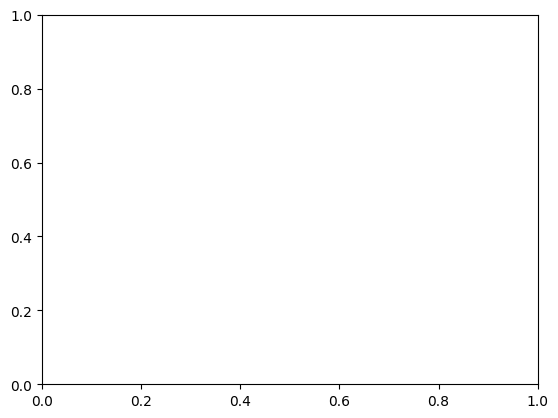

In [17]:
plt.scatter(X_train, X_test)
plt.plot(y_pred, y_test)
plt.show()

In [67]:
df.price.max()

10500000.0

In [35]:
model = LinearRegression()
model.fit(X_train,y_train)

ValueError: could not convert string to float: 'APARTMENT'